# ChEMBL Database
The ChEMBL Database is a database that contains curated bioactivity data of more than 2 million compounds. It is compiled from more than 76,000 documents, 1.2 million assays and the data spans 13,000 targets and 1,800 cells and 33,000 indications. [Data as of March 25, 2020; ChEMBL version 26].

## Importing Libraries

#### For installing chembl_webresource_client
      ==> pip install chembl_webresource_client

In [ ]:
! pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 636 kB 11.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.0.1 which is incompatible.


In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

# Part 1 : Data Collection

In [ ]:
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


## **Select and retrieve bioactivity data for *SARS coronavirus 3C-like proteinase* (first entry)**
We will assign the fifth entry (which corresponds to the target protein, Human Acetylcholinesterase) to the selected_target variable

In [ ]:
selected_target = targets.target_chembl_id[4]
selected_target

'CHEMBL3927'

#### Here, we will retrieve only bioactivity data for coronavirus 3C-like proteinase  (CHEMBL3927) that are reported as IC50 values in nM (nanomolar) unit.

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
df=pd.DataFrame.from_dict(res)
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '18.28', 'le': '0.33', 'lle': '3.25', ...",CHEMBL187579,None,CHEMBL187579,5.14,False,http://www.openphacts.org/units/Nanomolar,384103,=,1,True,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '12.10', 'le': '0.33', 'lle': '1.22', ...",CHEMBL188487,None,CHEMBL188487,5.03,False,http://www.openphacts.org/units/Nanomolar,383984,=,1,True,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '11.56', 'le': '0.29', 'lle': '2.21', ...",CHEMBL185698,None,CHEMBL185698,4.87,False,http://www.openphacts.org/units/Nanomolar,384106,=,1,True,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.64', 'le': '0.32', 'lle': '1.25', ...",CHEMBL426082,None,CHEMBL426082,4.88,False,http://www.openphacts.org/units/Nanomolar,384075,=,1,True,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.84', 'le': '0.32', 'lle': '2.16', ...",CHEMBL187717,None,CHEMBL187717,5.70,False,http://www.openphacts.org/units/Nanomolar,384234,=,1,True,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0


Finally we will save the resulting bioactivity data to a CSV file **bioactivity_data.csv**.

In [ ]:
df.to_csv('bioactivity_data.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Handling missing data**
If any compounds has missing value for the **standard_value** column then drop it.

In [ ]:
df2=df[df.type.notna()]

Apparently, we didn't find any missing value but it is always a good practice to check for missing values.

# **Data pre-processing of the bioactivity data**

Compounds having value less than **1000nM** will be considered to be **Active**.

Those greater than **1000nM** and less than **10000nM** will be considered to be **Intermediate**.

And those greater than **10000nM** will be considered to be **Inactive**.

In [ ]:
bioactivity_class=[]
for i in df2.standard_value:
    if float(i)>=10000:
        bioactivity_class.append("inactive")
    elif 1 < float(i) <= 1000 :
        bioactivity_class.append("active")
    else:
        bioactivity_class.append("intermediate")
    

In [ ]:
selection = ["molecule_chembl_id","canonical_smiles","standard_value"]
df3 = df2[selection]

In [ ]:
df3 = pd.concat([df3,pd.Series(bioactivity_class,name="bioactivity_class")],axis=1)

In [ ]:
df3.head(2)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate


In [ ]:
df3.to_csv('bioactivity_preproccessed_data.csv', index=False)

# **Part 2 : Exploratory Data Analysis (EDA)**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [ ]:
df_lipinski = lipinski(df3.canonical_smiles)

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [ ]:
df_combined = pd.concat([df3,df_lipinski],axis=1)
df_combined['standard_value']=df_combined['standard_value'].astype(np.float64)

In [ ]:
df_combined.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0


In [ ]:
import seaborn as sns
import numpy as np

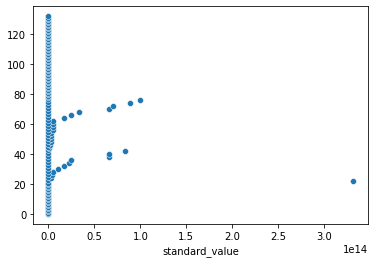

In [ ]:
sns.scatterplot(x=df_combined["standard_value"],y=range(len(df_combined["standard_value"])))

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb


def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
df_combined.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

e will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [ ]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [ ]:
df_norm.standard_value_norm.describe()

count    1.330000e+02
mean     2.110164e+07
std      4.089714e+07
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [ ]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [ ]:
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

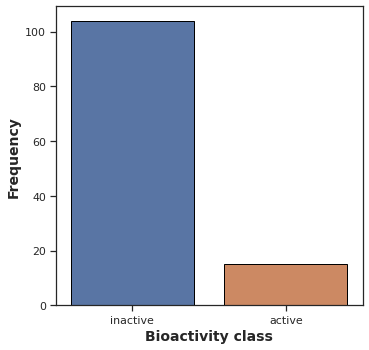

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

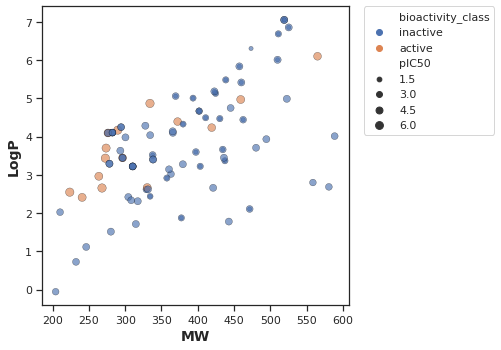

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.65)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

 ### **Box plots**
 #### **pIC50 value**

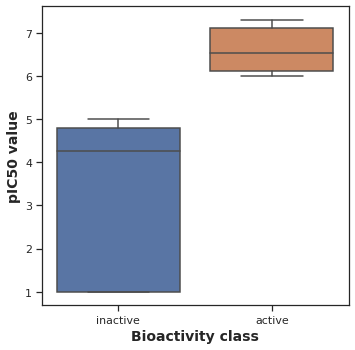

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.662636e-10,0.05,Different distribution (reject H0)


#### **MW**

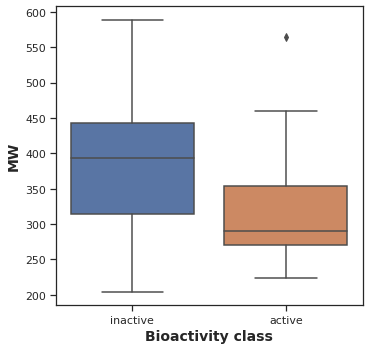

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,409.5,0.001525,0.05,Different distribution (reject H0)


#### **LogP**

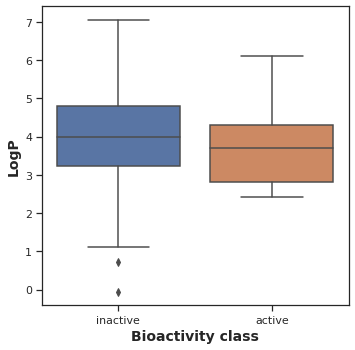

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.295805,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

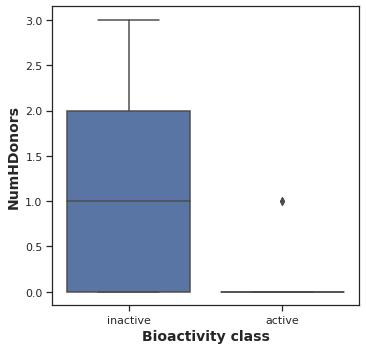

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,299.5,0.000024,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

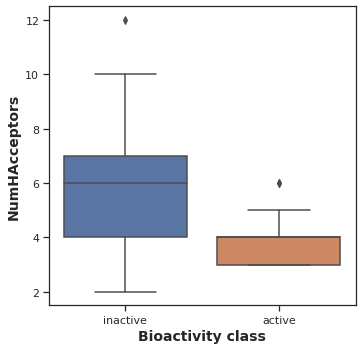

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,415.0,0.001557,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**
##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: bioactivity_data.csv (deflated 90%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 12%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: mannwhitneyu_MW.csv (deflated 9%)
  adding: plot_MW_vs_LogP.pdf (deflated 15%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: bioactivity_preproccessed_data.csv (deflated 80%)
  adding: plot_MW.pdf (deflated 38%)
  adding: plot_NumHDonors.pdf (deflated 38%)


# **Bioinformatics Project - Computational Drug Discovery [Part 3] Descriptor Calculation and Dataset Preparation**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 3**, we will be calculating molecular descriptors that are essentially quantitative description of the compounds in the dataset. Finally, we will be preparing this into a dataset for subsequent model building in Part 4.

## **Download PaDEL-Descriptor**

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2021-08-15 19:03:49--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-08-15 19:03:49--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   140MB/s    in 0.2s    

2021-08-15 19:03:49 (140 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2021-08-15 19:03:49--  https://github

In [ ]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

## **Load bioactivity data**

Download the curated ChEMBL bioactivity data that has been pre-processed from Parts 1 and 2 of this Bioinformatics Project series. Here we will be using the **bioactivity_data_3class_pIC50.csv** file that essentially contain the pIC50 values that we will be using for building a regression model.

In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv

--2021-08-15 19:03:50--  https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 655414 (640K) [text/plain]
Saving to: ‘acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv’

acetylcholinesteras 100%[===================>] 640.05K  --.-KB/s    in 0.05s   

2021-08-15 19:03:50 (13.2 MB/s) - ‘acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv’ saved [655414/655414]



In [ ]:
import pandas as pd
df3 = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
df3

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...,...
4690,4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,intermediate,511.150,7.07230,2.0,3.0,5.612610
4691,4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,intermediate,511.150,7.07230,2.0,3.0,5.595166
4692,4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,intermediate,555.601,7.18140,2.0,3.0,5.419075
4693,4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,intermediate,521.702,6.32710,2.0,5.0,5.460924


In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478


In [ ]:
! cat molecule.smi | wc -l

4695


## **Calculate fingerprint descriptors**


### **Calculate PaDEL descriptors**

In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
# ! bash padel.sh
! ls -l

total 109532
-rw-r--r-- 1 root root   655414 Aug 15 19:03 acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv
-rw-r--r-- 1 root root    70334 Aug 15 19:01 bioactivity_data.csv
-rw-r--r-- 1 root root    10578 Aug 15 19:02 bioactivity_preproccessed_data.csv
drwx------ 5 root root     4096 Aug 15 19:02 drive
drwxr-xr-x 3 root root     4096 Aug 15 19:03 __MACOSX
-rw-r--r-- 1 root root      121 Aug 15 19:03 mannwhitneyu_LogP.csv
-rw-r--r-- 1 root root      119 Aug 15 19:03 mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      130 Aug 15 19:03 mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      128 Aug 15 19:03 mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root      121 Aug 15 19:03 mannwhitneyu_pIC50.csv
-rwxr-xr-x 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh
-rw-r--r-- 1 root root   310658 Aug 15 19:03 molecule.smi
drwxrwxr-x 4 root root     4096 May 30  2020 PaDEL-Descriptor
-rw-r--r-- 1 root root      231 Aug 15 19:03 padel.sh
-rw-r--r-- 1 root root 2576

## **Preparing the X and Y Data Matrices**

### **X data matrix**

In [ ]:
df3_X = pd.read_csv("descriptors_output.csv")
df3_X.head(6)

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CHEMBL130098,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df3_X = df3_X.drop(columns=['Name'])

In [ ]:
df3_X.head(5)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Y variable**
### **Convert IC50 to pIC50**

In [ ]:
df3_Y = df3['pIC50']
df3_Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
4690    5.612610
4691    5.595166
4692    5.419075
4693    5.460924
4694    5.555955
Name: pIC50, Length: 4695, dtype: float64

## **Combining X and Y variable**

In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.612610
4691,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.595166
4692,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.419075
4693,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.460924


In [ ]:
dataset3.to_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

# **Bioinformatics Project - Computational Drug Discovery [Part 4] Regression Models with Random Forest**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 4**, we will be building a regression model of acetylcholinesterase inhibitors using the random forest algorithm.

## **1. Import libraries**

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## **2. Load the data set**

In [ ]:
! wget https://github.com/dataprofessor/data/raw/master/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv

--2021-08-15 19:51:37--  https://github.com/dataprofessor/data/raw/master/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv [following]
--2021-08-15 19:51:37--  https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8363909 (8.0M) [text/plain]
Saving to: ‘acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_

In [ ]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

## **3. Input features**
The ***Acetylcholinesterase*** data set contains 881 input features and 1 output variable (pIC50 values).

### **3.1. Input features**

In [ ]:
X = df.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4691,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4692,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4693,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **3.2. Output features**

In [ ]:
Y = df.pIC50
Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
4690    5.612610
4691    5.595166
4692    5.419075
4693    5.460924
4694    5.555955
Name: pIC50, Length: 4695, dtype: float64

### **3.3. Let's examine the data dimension**

In [ ]:
X.shape

(4695, 881)

In [ ]:
Y.shape

(4695,)

### **3.4. Remove low variance features**

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [ ]:
X.shape

(4695, 137)

## **4. Data split (80/20 ratio)**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
X_train.shape, Y_train.shape

((3756, 137), (3756,))

In [ ]:
X_test.shape, Y_test.shape

((939, 137), (939,))

## **5. Building a Regression Model using Random Forest**

In [ ]:
np.random.seed(100)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.5123124480066096

In [ ]:
Y_pred = model.predict(X_test)

## **6. Scatter Plot of Experimental vs Predicted pIC50 Values**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


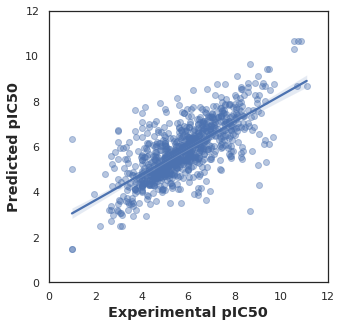

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()